# Conser-vision Practice Area: Image Classification

HOSTED BY DRIVENDATA

In this notebook I'm going to explore and identify animal species in a real world dataset of wildlife images for [the Conser-vision competition on DrivenData](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/page/409/).

The goal is to classify animal species that appear in camera trap images collected at the [Tai National Park](https://en.wikipedia.org/wiki/Ta%C3%AF_National_Park) in Côte d'Ivoire. Camera traps are one of the best tools available to study and monitor wildlife populations, and the enormous amounts of data they provide can be used to track different species for conservation efforts - once they are processed.

## 1. Let's get started
First of all, we want to import useful packages and the csv files.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm

import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from sklearn.metrics import ConfusionMatrixDisplay

from functions import *

# plotting default settings for better images
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams['figure.dpi']= 300
plt.rcParams['xtick.direction']= 'out'

torch.cuda.is_available()

True

Let us set up Pytorch so it will use the GPU when available from Google Colab:

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda:0' else {}
kwargs={'num_workers': 1, 'pin_memory': True}

cuda:0


In [ ]:
train_features = pd.read_csv("train_features.csv", index_col="id")
test_features = pd.read_csv("test_features.csv", index_col="id")
train_labels = pd.read_csv("train_labels.csv", index_col="id")

The `features` CSVs contain the image ID, filepath and site ID for each image. 

In [ ]:
train_features.head(2)

,filepath,site
id,,
ZJ000000,train_features/ZJ000000.jpg,S0120
ZJ000001,train_features/ZJ000001.jpg,S0069


In [ ]:
test_features.head(2)

,filepath,site
id,,
ZJ016488,test_features/ZJ016488.jpg,S0082
ZJ016489,test_features/ZJ016489.jpg,S0040


In [ ]:
train_features.shape[0]

16488

The `train_labels` CSV is an indicator matrix of the species identified in each of the training images. Some images are labeled as "blank" if no animal was detected.

In [ ]:
train_labels.head(3)

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's store a sorted list of the labels, so that we can sort the inputs and outputs to our model in a consistent way.

In [ ]:
species_labels = sorted(train_labels.columns)
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

## 2 Exploratory Data Analysis
Now let's see what some of the actual images look like. The code below iterates through a list of species and selects a single random image from each species to display, along with its image ID and label.

In [ ]:
random_state = 24

# grid with 8 positions, one for each label
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

# iterate through each species
for species, ax in zip(species_labels, axes.flat):
    # get an image ID for this species
    img_id = (
        train_labels[train_labels.loc[:,species] == 1]
        .sample(1, random_state=random_state)
        .index[0]
    )
    # reads the filepath and returns a numpy array
    img = mpimg.imread(train_features.loc[img_id].filepath)
    
    ax.imshow(img)
    ax.set_title(f"{img_id} | {species}")

Output hidden; open in https://colab.research.google.com to view.

### 2.1 Species distribution
Let's look at the distribution of species across the training set, first in terms of overall counts and then in percentage terms.

In [ ]:
train_labels.sum().sort_values(ascending=False)

monkey_prosimian    2492.0
antelope_duiker     2474.0
civet_genet         2423.0
leopard             2254.0
blank               2213.0
rodent              2013.0
bird                1641.0
hog                  978.0
dtype: float64

In [ ]:
train_labels.sum().sort_values(ascending=False)/train_labels.shape[0]

monkey_prosimian    0.151140
antelope_duiker     0.150049
civet_genet         0.146955
leopard             0.136705
blank               0.134219
rodent              0.122089
bird                0.099527
hog                 0.059316
dtype: float64

### 2.2 Camera trap sites
Let's look at the distribution of camera trap sites:

In [ ]:
count_sites = train_features.groupby('site').count().sort_values('filepath',ascending=False)
count_sites=count_sites.rename(columns={"filepath": "train_count"})
count_sites
test_sites=test_features.groupby('site').count().sort_values('filepath')
test_sites=test_sites.rename(columns={"filepath": "test_count"})
count_sites=count_sites.join(test_sites, how='outer')

print('Number of sites present in both training and test samples:')
count_sites.dropna(how='any').shape[0]

Number of sites present in both training and test samples:


0

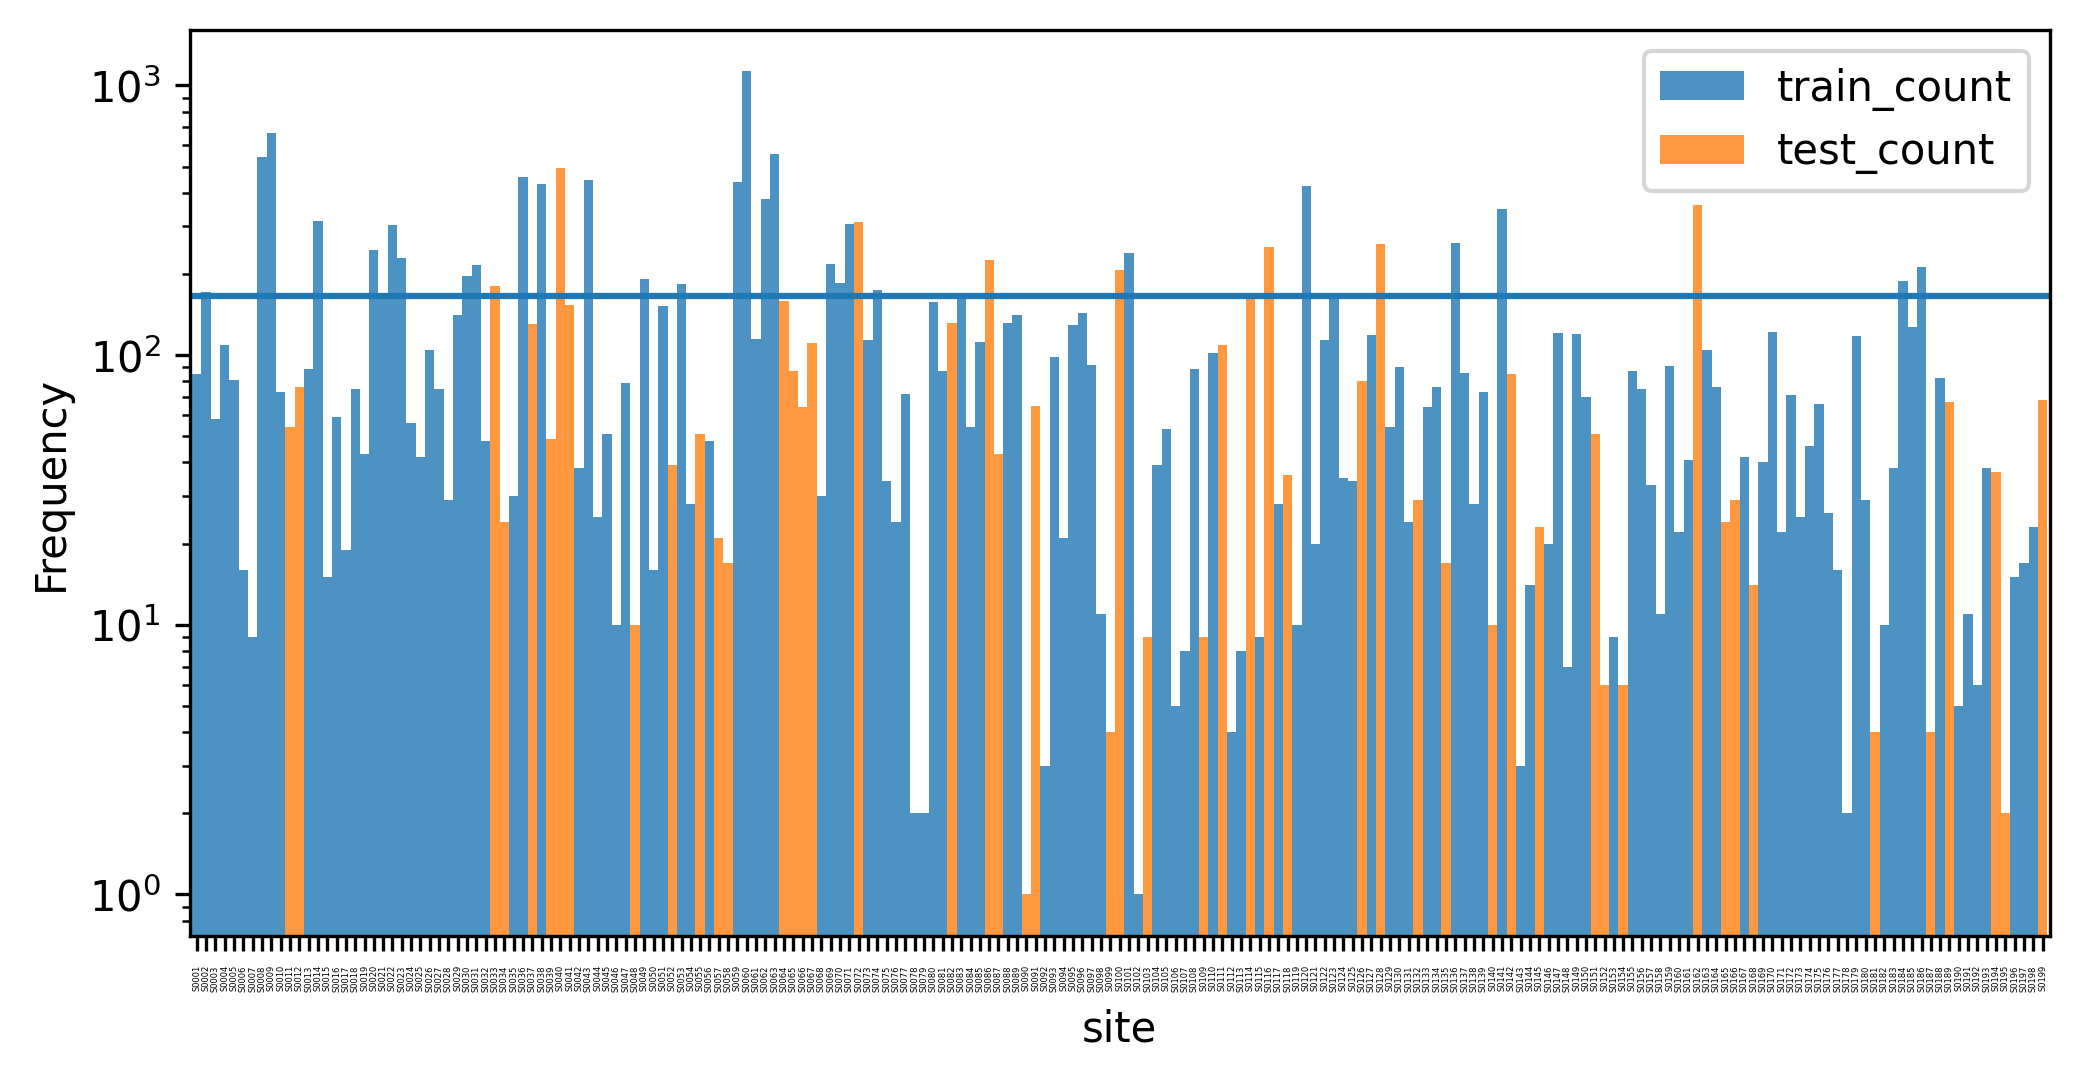

In [ ]:
count_sites.plot.bar(stacked=True,width=1,alpha=.8)
plt.yscale('log')
plt.ylabel('Frequency')
plt.xticks(fontsize=2)
plt.axhline(165)
plt.show()

In [ ]:
total_train_sites=train_features[['site']].nunique()[0]
low_repr_sites=count_sites.loc[count_sites.train_count<165].count()[0]
(f'Percentage of sites appearing in less than 1% of the training sample: {low_repr_sites/total_train_sites*100:.1f}%')

'Percentage of sites appearing in less than 1% of the training sample: 80.4%'

Most sites ($\sim 80\%$) have a small representation ($<1\% \simeq165$, see blue horizontal line on the histogram above) . Also, there is no match between the sites in the training sample and the test sample, which might make the test harder for the model.

### 2.3 Image size exploration
Let's go on to analyze the shapes of the images. We are interested in the pizel width and height, colors ("depth" of the image) and the ratio between height and width.

In [ ]:
# retrieve images' sizes
for idx,row in train_features.iterrows():
    # reads the filepath and returns a numpy array
    img = mpimg.imread(row.filepath)
    #print(img.shape,'ratio',img.shape[1]/img.shape[0])
    
    #save sizes to df
    train_features.loc[idx,'height']=img.shape[0]
    train_features.loc[idx,'width']=img.shape[1]
    if len(img.shape)>2:
      train_features.loc[idx,'depth']=img.shape[2]
    else:
      train_features.loc[idx,'depth']=1
    train_features.loc[idx,'size_ratio']=img.shape[1]/img.shape[0]

In [ ]:
train_features[['height','weidth','depth','ratio']].hist();

## 3 Train and test sets

In [ ]:
x_train, x_eval, y_train, y_eval= make_train_test_sets(train_labels, train_features, frac=1)

In [ ]:
split_pcts = pd.DataFrame(
    {
        "train": y_train.idxmax(axis=1).value_counts(normalize=True),
        "eval": y_eval.idxmax(axis=1).value_counts(normalize=True),
    }
)
print("Species percentages by split")
(split_pcts.fillna(0) * 100).astype(int)

Species percentages by split


,train,eval
monkey_prosimian,15,15
antelope_duiker,15,15
civet_genet,14,14
leopard,13,13
blank,13,13
rodent,12,12
bird,9,9
hog,5,5


## 4 Build the model

### 4.1 The dataset
First, we'll create an `ImagesDataset` class that will define how we access our data and any transformations we might want to apply. 

This new class will inherit from the PyTorch [`Dataset`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) class, but we'll also need to define our own `__init__`, `__len__` and `__getitem__` **special methods**:
* **`__init__`** will instantiate the dataset object with two dataframes: an `x_train` df containing image IDs and image file paths, and a `y_train` df containing image IDs and labels. This will run once when we first create the dataset object, e.g. with `dataset = ImagesDataset(x_train, y_train)`.
* **`__getitem__`** will define how we access a sample from the data. This method gets called whenever we use an indexing operation like `dataset[index]`. In this case, whenever accessing a particular image sample (for example, to get the first image we'd do `dataset[0]`) the following will happen:
  * look up the image filepath using the index
  * load the image with [`PIL.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html)
  * apply some transformations (more on this below)
  * return a dictionary containing the image ID, the image itself as a Tensor, and a label (if it exists)
* **`__len__`** simply returns the size of the dataset, which we do by calling `len` on the input dataframe.

In [ ]:
class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_df, y_df=None):
        self.data = x_df
        self.label = y_df
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __getitem__(self, index):
        image = Image.open(self.data.iloc[index]["filepath"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.index[index]
        # if we don't have labels (e.g. for test set) just return the image and image id
        if self.label is None:
            sample = {"image_id": image_id, "image": image}
        else:
            label = torch.tensor(self.label.iloc[index].values, 
                                 dtype=torch.float)
            sample = {"image_id": image_id, "image": image, "label": label}
        return sample

    def __len__(self):
        return len(self.data)

Notice that we are also defining a set of **transformations**, which are defined in the `__init__` and called in the `__getitem__` special methods. These are applied to each image before returning it. Here's what each of those transformations do and why:

* `transforms.Resize((224, 224))` ResNet50 was trained on images of size 224x224 so we resize to the same dimensions here. See [pytorch docs](https://pytorch.org/vision/stable/models.html) and the [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf).
* `transforms.ToTensor()` converts the image to a tensor. Since we are passing in a PIL Image at this point, PyTorch can recognize it as an RGB image and will automatically convert the input values which are in the range [0, 255] to a range of [0, 1]. See more from the [PyTorch docs](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html).
* `transforms.Normalize(...)` normalizes the image tensors using the mean and standard deviation of ImageNet images. Because this transformation was applied to images when training the ResNet model, we want to do the same here with our images. See more from the [PyTorch docs on pretrained models](https://pytorch.org/vision/stable/models.html).

### 4.2 The DataLoader
Next, we need to load the dataset into a dataloader. The `DataLoader` class lets us iterate through our dataset in batches. We are chosing here a batch size of 32 images.

In [ ]:
train_dataset = ImagesDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, **kwargs)

## 5 Training
Now it's time to start building our model and then training it.

We'll use a pretrained ResNet50 model as our backbone. ResNets are one of the more popular networks for image classification tasks. The pretrained model outputs a 2048-dimension embedding, which we will then connect to two more dense layers, with a ReLU and Dropout step in between. 

These final layers, defined in `model.fc`, are the new "head" of our model, and allow us to transform the image embeddings produced by the pretrained "backbone" into the 8-dimensional output required to learn the species classification task we're tackling here. Prior to redefining it below, `model.fc` would be the final, dense layer connecting the 2048-dimension embedding to a 1000-dimension output (corresponding to the 1000 ImageNet classes that the pretrained model was trained on). We will instead prepare the model for the current task by redefining `model.fc` to produce an 8-dimensional output corresponding to our 8 species classes (including blanks). 

We'll also add a couple more layers in between. The `ReLU` layer introduces non-linearity into the model head, in effect activating important features and suppressing noise. And the `Dropout` layer is a commonly used regularization component that randomly drops some nodes from the previous layer's outputs (10% of nodes in this case) during each training step, mitigating our risk of overfitting.

In [ ]:
#import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

# Using pretrained weights:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
#model = models.resnet50(pretrained=True) #deprecated, equivalent to the above
model.fc = nn.Sequential(
    nn.Linear(2048, 100),  # dense layer takes a 2048-dim input and outputs 100-dim
    nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
    nn.Dropout(0.1),  # common technique to mitigate overfitting
    nn.Linear(
        100, 8
    ),  # final dense layer outputs 8-dim corresponding to our target classes
)

freeze_layers(model,n_layers=7)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 5.1 Define our loss function
Cross entropy loss (or log loss) is a commonly used loss function for multi-class (not multi-label) image classification. We'll use this to compute loss for each training batch and then update our parameters accordingly. 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)

### 5.2 Train the model
We're now ready to train our model!

We'll start simple and just run it for one epoch, but feel free to run it for more `num_epochs` if you've got the time. We hope to see a decreasing loss as training progresses, which will provide some evidence that the model is learning. Note that we haven't frozen any weights in the pretrained model, a choice which you may want to revisit and we discuss in a little more detail below.

For each epoch we'll iterate through the batches, and for each batch we'll do the following:
1. Zero out the gradients. PyTorch will sum the gradients from past batches when doing its backward pass, so in order to make sure we are only using the gradients computed for the current batch, we zero out the gradients at the beginning of each batch.
2. Run the forward pass.
3. Compute the loss and track it.
4. Compute our gradients and update our weight parameters.

In [ ]:
model,tracking_loss = model_train(model,train_dataloader,criterion,optimizer,device,num_epochs=1)

Starting epoch 1


100%|██████████| 387/387 [1:06:56<00:00, 10.38s/it]


Now let's plot the loss by epoch and batch. The x-axis here is a tuple of `(epoch, batch)`.

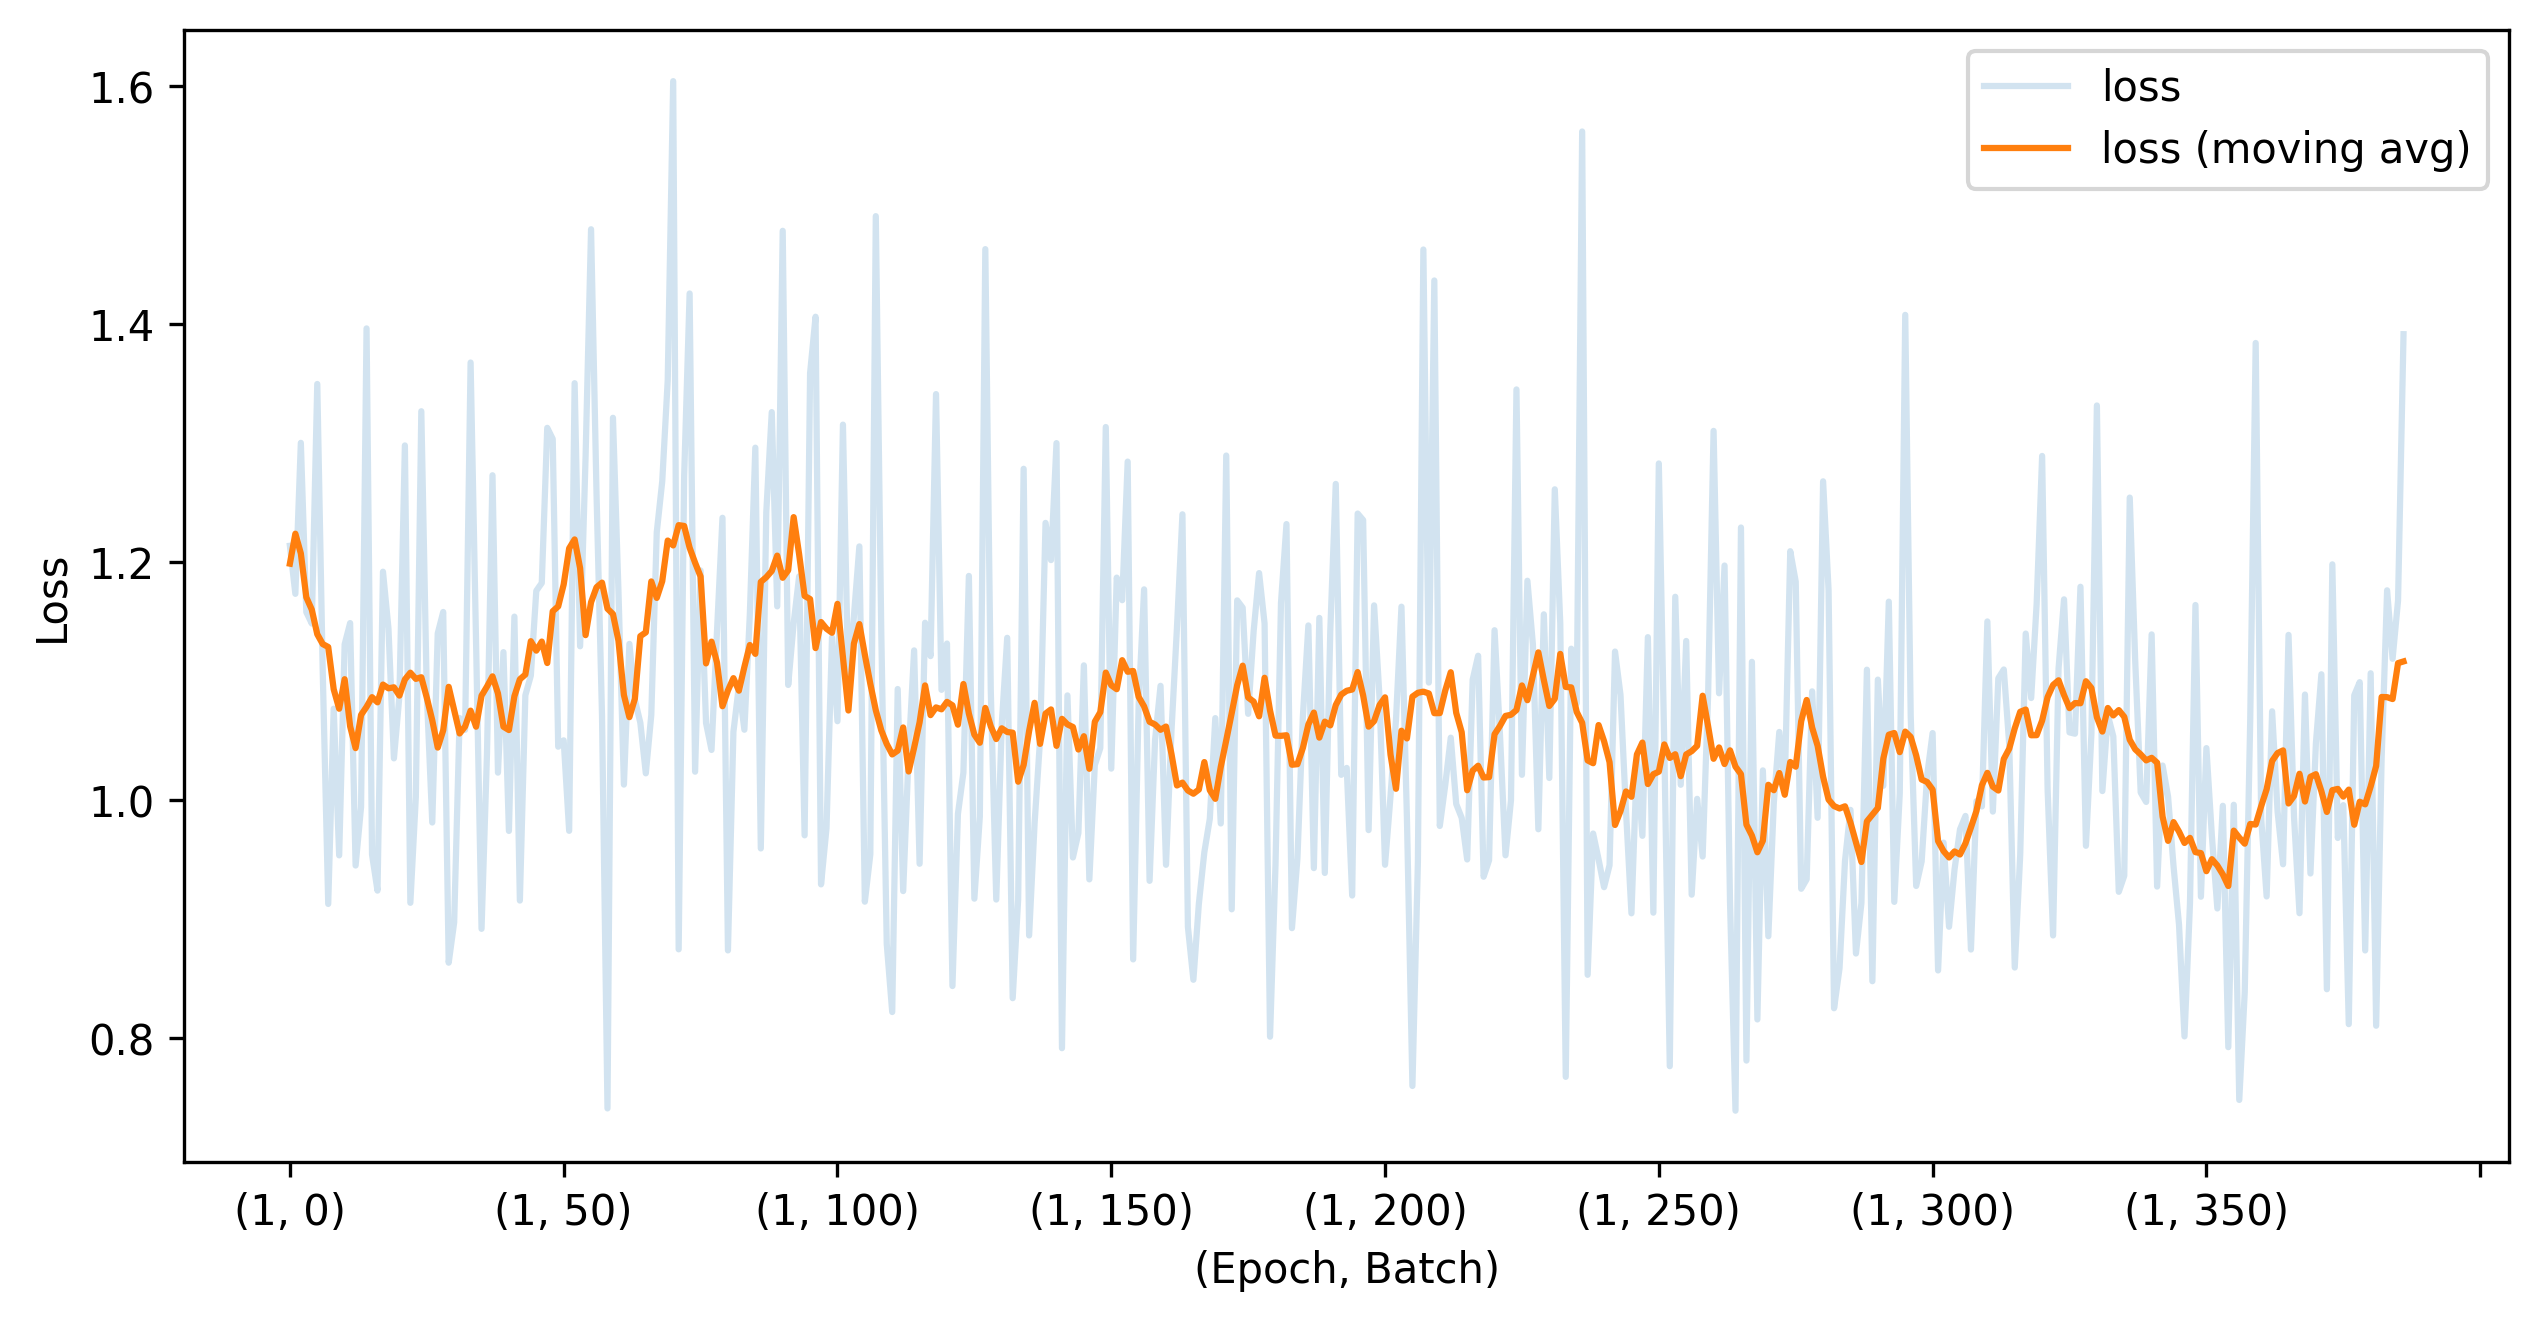

In [ ]:
f = plot_loss(tracking_loss)
plt.savefig('20221120_ResNet50_7freeze_DEFAULT_3epoch_lr1e-5'+'_loss.pdf', format = 'pdf', bbox_inches = 'tight',transparent=True) ;
plt.show()

### 5.3 Save the model
We have the model loaded in memory already, so we don't really need to save the model, but it's often useful to do this so we can use it again later.

In [ ]:
torch.save(model, "20221118_ResNet50_7freeze_DEFAULT_3epoch_lr1e-5.pth")

## 6 Evaluation
Let's find out how our model will do on new data. Let's reload our saved model and try generating some predictions on the evaluation split we created earlier.

In [ ]:
# 20221108_ResNet50_nofreeze_IMAGENET1KV1_1epoch, 20221114_ResNet50_freeze_DEFAULT_1epoch, 
# 20221115_ResNet50_7freeze_DEFAULT_1epoch, 20221117_ResNet50_7freeze_DEFAULT_2epoch_lr1e-4,
# 20221118_ResNet50_7freeze_DEFAULT_3epoch_lr1e-5
filename="20221118_ResNet50_7freeze_DEFAULT_3epoch_lr1e-5"
model = torch.load(filename+".pth")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

We create the eval dataset and dataloader just like we did earlier with the training dataset and dataloader:

In [ ]:
eval_dataset = ImagesDataset(x_eval, y_eval)
eval_dataloader = DataLoader(eval_dataset, batch_size=32, **kwargs)

### 6.0.1 See the model

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
!pip install hiddenlayer
from torchsummary import summary
import hiddenlayer as hl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
summary(model, input_size=(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           9,408
       BatchNorm2d-2         [-1, 64, 100, 100]             128
              ReLU-3         [-1, 64, 100, 100]               0
         MaxPool2d-4           [-1, 64, 50, 50]               0
            Conv2d-5           [-1, 64, 50, 50]           4,096
       BatchNorm2d-6           [-1, 64, 50, 50]             128
              ReLU-7           [-1, 64, 50, 50]               0
            Conv2d-8           [-1, 64, 50, 50]          36,864
       BatchNorm2d-9           [-1, 64, 50, 50]             128
             ReLU-10           [-1, 64, 50, 50]               0
           Conv2d-11          [-1, 256, 50, 50]          16,384
      BatchNorm2d-12          [-1, 256, 50, 50]             512
           Conv2d-13          [-1, 256, 50, 50]          16,384
      BatchNorm2d-14          [-1, 256,

### 6.1 Make predictions
We'll iterate through the eval dataloader in batches, just like we did for training, but this time we aren't going to need to compute gradients or update weights. For each batch, we'll do the following:
1. Run the forward pass to get the model output or logits
2. Apply a softmax function to convert the logits into probability space with range[0,1]. During training, the softmax operation was handled internally by `nn.CrossEntropyLoss`. We aren't computing the loss now because we are just doing evaluation, but we still want the predictions to be in the range[0,1]. 
3. Store the results in a dataframe for further analysis

In [ ]:
eval_preds_df = model_predict(model,eval_dataloader,species_labels,device)

100%|██████████| 129/129 [19:56<00:00,  9.27s/it]


In [ ]:
print("Predicted labels (eval):")
eval_preds_df.idxmax(axis=1).value_counts()

Predicted labels (eval):


monkey_prosimian    993
antelope_duiker     755
civet_genet         571
rodent              561
leopard             495
blank               407
hog                 193
bird                147
dtype: int64

In [ ]:
print("True labels (eval):")
y_eval.idxmax(axis=1).value_counts()

True labels (eval):


monkey_prosimian    623
antelope_duiker     619
civet_genet         606
leopard             564
blank               553
rodent              503
bird                410
hog                 244
dtype: int64

### 6.2 Accuracy
Now let's compute how accurate our model is and compare that against some trivial baseline models. First let's get the labels with the highest score for each image.

In [ ]:
eval_predictions = eval_preds_df.idxmax(axis=1)

Random guessing across 8 classes would yield an accuracy of 12.5% (1/8). But we could construct a slightly better trivial model by always guessing the most common class ("monkey_prosimian" images in this case).

If we were to always guess that an image is `monkey_prosimian`, we could achieve accuracy of 15.8%.

In [ ]:
eval_true = y_eval.idxmax(axis=1)

(eval_true == "monkey_prosimian").sum() / len(eval_predictions)

0.15114022319262493

Let's see how our model compares. We take the species with the highest score for each image (`eval_predictions`) and compare that to the true labels.

In [ ]:
correct = (eval_predictions == eval_true).sum()
accuracy = correct / len(eval_predictions)
accuracy

0.5943716642406599

Let's look at the predictions from another angle. 

We can see from the confusion matrix below that our model does reasonably well on some species, but we have plenty of room for improvement on antelopes, birds, hogs and blanks.

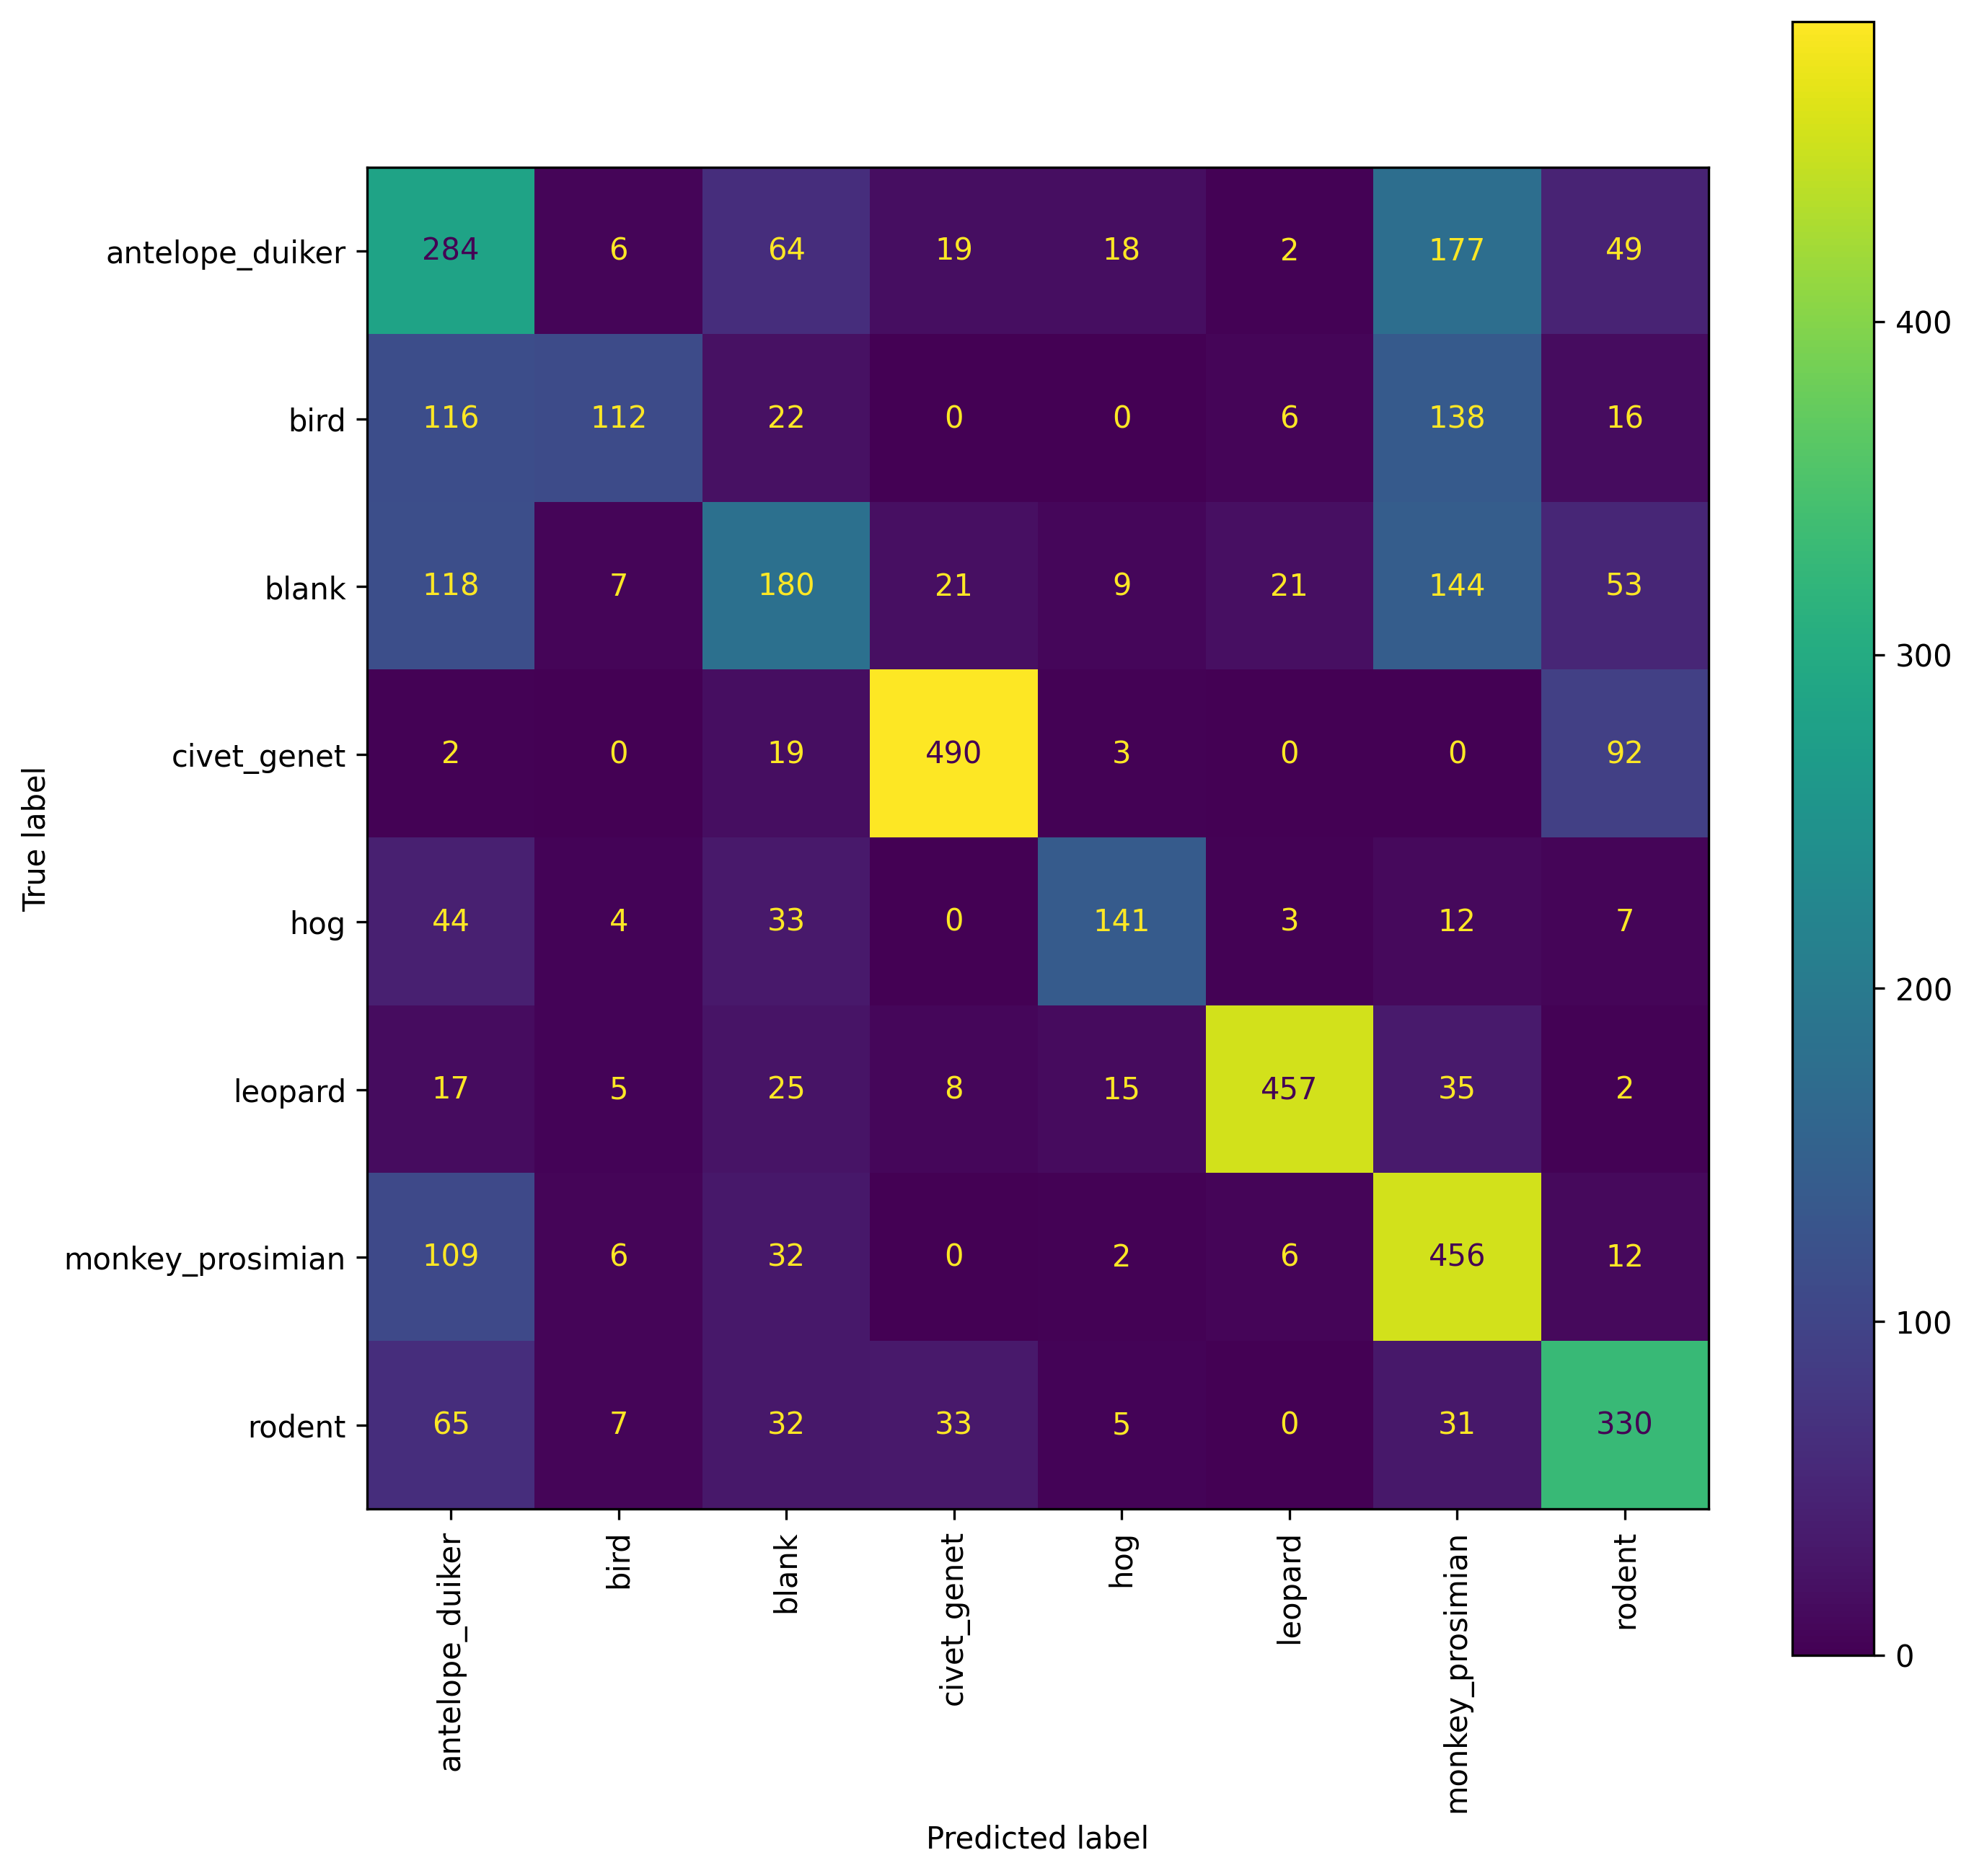

In [ ]:
fig = confusion_matrix(y_eval,eval_preds_df)
plt.savefig(filename+'_confmatrix.pdf', format = 'pdf', bbox_inches = 'tight',transparent=True) ;
plt.show()

## 7. Create submission
We need to create predictions for the **competition test set** (not the eval set we used above). You don't have labels for these.

We'll create predictions in the same way we did for the `eval` set, but this time using the `test_features` we downloaded from the [competition website](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/data/).

In [ ]:
test_dataset = ImagesDataset(test_features.filepath.to_frame())
test_dataloader = DataLoader(test_dataset, batch_size=32, **kwargs)

In [ ]:
submission_df = model_predict(model,test_dataloader,species_labels,device)

100%|██████████| 140/140 [26:29<00:00, 11.35s/it]


In [ ]:
submission_csv(submission_df,filename+'.csv')


## 7 Second model

In [ ]:
#import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

# Using pretrained weights:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
#model = models.resnet50(pretrained=True) #deprecated, equivalent to the above
model.fc = nn.Sequential(
    nn.Linear(2048, 100),  # dense layer takes a 2048-dim input and outputs 100-dim
    nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
    nn.Dropout(0.1),  # common technique to mitigate overfitting
    nn.Linear(
        100, 8
    ),  # final dense layer outputs 8-dim corresponding to our target classes
)

n_layers = 9
ct = 0
for child in model.children():
  ct += 1
  if ct <= n_layers:
      #print(child)
      for param in child.parameters():
          param.requires_grad = False

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
num_epochs = 1

tracking_loss = {}

for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch}")

    # iterate through the dataloader batches. tqdm keeps track of progress.
    for batch_n, batch in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):

        # 1) zero out the parameter gradients so that gradients from previous batches are not used in this step
        optimizer.zero_grad()

        # 2) run the foward step on this batch of images
        outputs = model(batch["image"])

        # 3) compute the loss
        loss = criterion(outputs, batch["label"])
        # let's keep track of the loss by epoch and batch
        tracking_loss[(epoch, batch_n)] = float(loss)

        # 4) compute our gradients
        loss.backward()
        # update our weights
        optimizer.step()

Starting epoch 1


100%|██████████| 387/387 [39:00<00:00,  6.05s/it]


In [ ]:
torch.save(model, "20221114_ResNet50_freeze_DEFAULT_2epoch.pth")

In [ ]:
model = torch.load("20221114_ResNet50_freeze_DEFAULT_1epoch.pth")

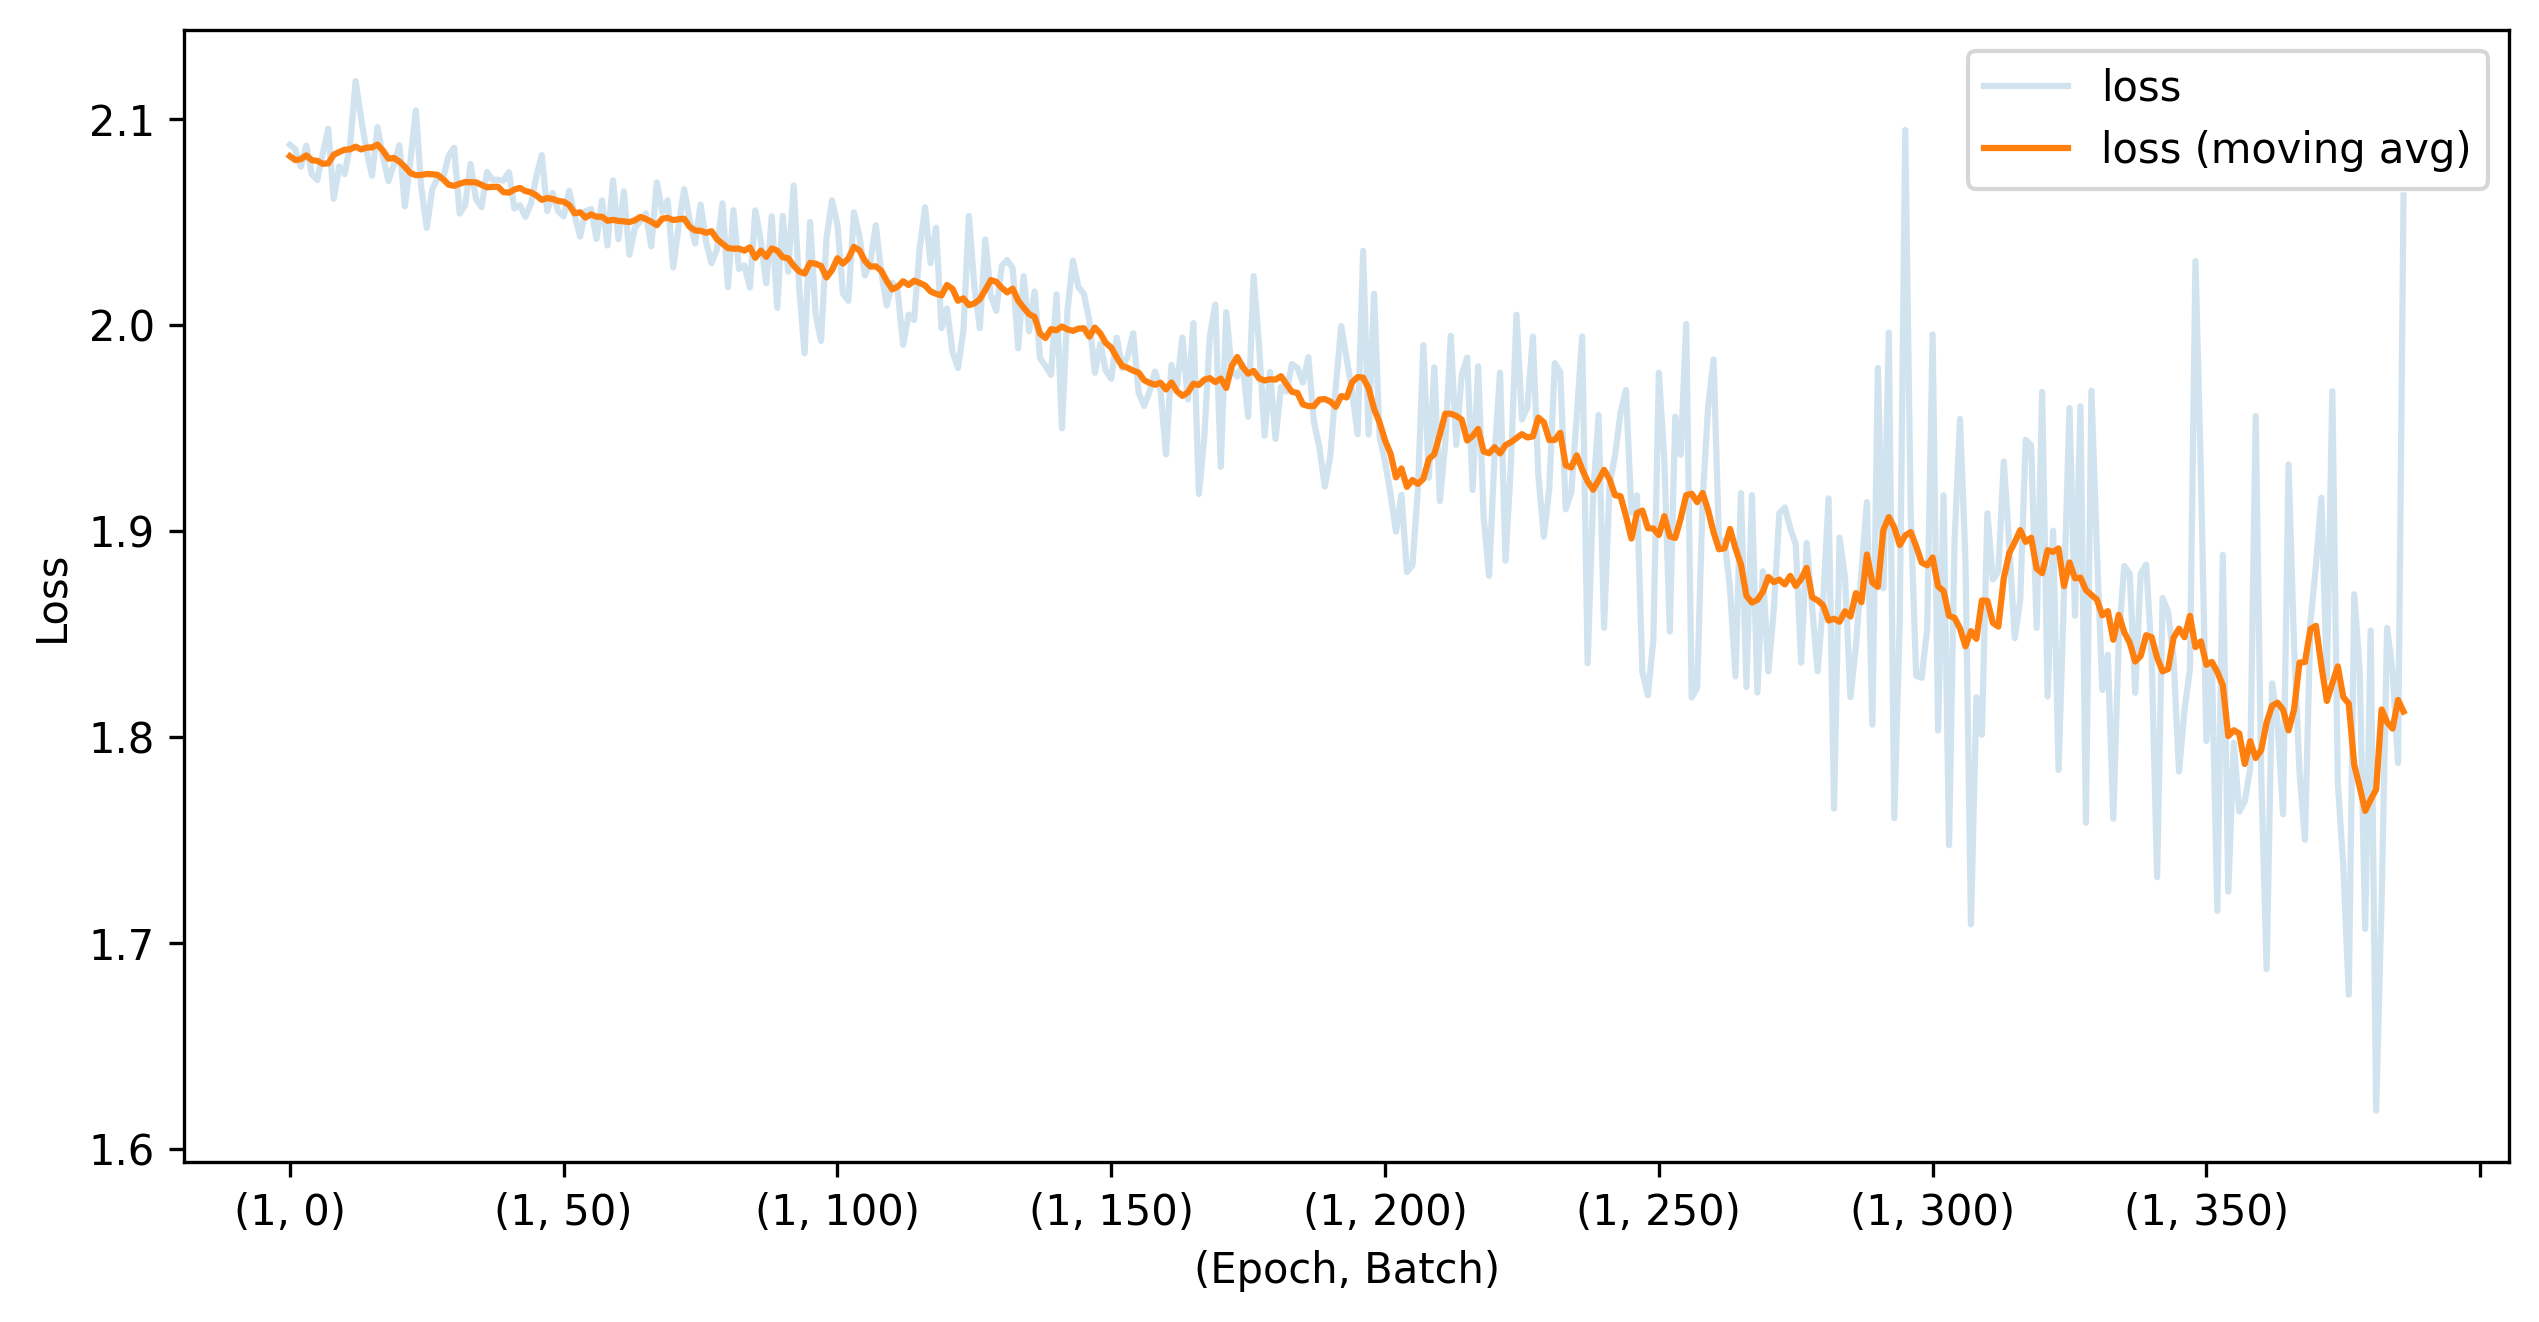

In [ ]:
tracking_loss = pd.Series(tracking_loss)

plt.figure(figsize=(10, 5))
tracking_loss.plot(alpha=0.2, label="loss")
tracking_loss.rolling(center=True, min_periods=1, window=10).mean().plot(
    label="loss (moving avg)"
)
plt.xlabel("(Epoch, Batch)")
plt.ylabel("Loss")
plt.legend(loc=0)
plt.show()

## Git commands
These are a few useful cells to push my work to my Github repository. As such, they are not part of the classification problem and are left here at the bottom of the notebook for practical reasons.

In [1]:
%ls

sample_data/


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd 'drive/MyDrive/Conser-vision_Practice_Area_Image_Classification/competition_VfIpjyh'
%ls

/content/drive/MyDrive/Conser-vision_Practice_Area_Image_Classification/competition_VfIpjyh
 20221108_ResNet50_nofreeze_IMAGENET1KV1_1epoch_confmatrix.pdf
 20221108_ResNet50_nofreeze_IMAGENET1KV1_1epoch.pth
 20221108_ResNet50_nofreeze_IMAGENET1KV1_1epoch_s1.7631.csv
 20221114_ResNet50_freeze_DEFAULT_1epoch_confmatrix.pdf
 20221114_ResNet50_freeze_DEFAULT_1epoch.pth
 20221114_ResNet50_freeze_DEFAULT_1epoch_s1.9411.csv
 20221114_ResNet50_freeze_DEFAULT_2epoch.pth
 20221115_ResNet50_7freeze_DEFAULT_1epoch_confmatrix.pdf
 20221115_ResNet50_7freeze_DEFAULT_1epoch_loss.pdf
 20221115_ResNet50_7freeze_DEFAULT_1epoch.pth
 20221115_ResNet50_7freeze_DEFAULT_1epoch_s1.7626.csv
 20221117_ResNet50_7freeze_DEFAULT_2epoch_confmatrix.pdf
 20221117_ResNet50_7freeze_DEFAULT_2epoch_loss.pdf
 20221117_ResNet50_7freeze_DEFAULT_2epoch_lr1e-4_confmatrix.pdf
 20221117_ResNet50_7freeze_DEFAULT_2epoch_lr1e-4_loss.pdf
 20221117_ResNet50_7freeze_DEFAULT_2epoch_lr1e-4.pth
 20221117_ResNet50_7freeze_DEFAULT_2epoch_l

In [6]:
!git config --global user.email "carrarorosamaria@gmail.com"
!git config --global user.name "RosCarraro"

In [7]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   Conser-vision_classification.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	20221108_ResNet50_nofreeze_IMAGENET1KV1_1epoch_confmatrix.pdf
	20221114_ResNet50_freeze_DEFAULT_1epoch.pth
	20221114_ResNet50_freeze_DEFAULT_1epoch_confmatrix.pdf
	20221114_ResNet50_freeze_DEFAULT_1epoch_s1.9411.csv
	20221114_ResNet50_freeze_DEFAULT_2epoch.pth
	20221115_ResNet50_7freeze_DEFAULT_1epoch.pth
	20221115_ResNet50_7freeze_DEFAULT_1epoch_confmatrix.pdf
	20221115_ResNet50_7freeze_DEFAULT_1epoch_loss.pdf
	20221115_ResNet50_7freeze_DEFAULT_1epoch_s1.7626.csv
	20221117_ResNet50_7freeze_DEFAULT_2epoch.pth
	20221117_ResNet50_7freeze_DEFAULT_2epoch_confmatrix.pdf
	20221117_ResNet50_7freeze_DEFAULT_2epoch_loss.pdf
	20221117_Res

In [ ]:
!git add Conser-vision_classification.ipynb

In [ ]:
!git add 20221108_ResNet50_nofreeze_IMAGENET1KV1_1epoch.pth
!git add 20221108_ResNet50_nofreeze_IMAGENET1KV1_1epoch_s1.7631.csv

In [ ]:
!git commit -m "Ran 1 epoch with the same model but using 100% of training data. Improved benchmark to a score 1.7631. Adding model and test predictions."

[main 51b17a3] Ran 1 epoch with the same model but using 100% of training data. Improved benchmark to a score 1.7631. Adding model and test predictions.
 3 files changed, 4466 insertions(+), 1 deletion(-)
 create mode 100644 20221108_ResNet50_nofreeze_IMAGENET1KV1_1epoch.pth
 create mode 100644 20221108_ResNet50_nofreeze_IMAGENET1KV1_1epoch_s1.7631.csv
 rewrite Conser-vision_classification.ipynb (90%)


In [ ]:
!git push -u origin main


Counting objects: 5, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 84.88 MiB | 11.28 MiB/s, done.
Total 5 (delta 0), reused 0 (delta 0)
remote: warning: See http://git.io/iEPt8g for more information.
remote: warning: File 20221108_ResNet50_nofreeze_IMAGENET1KV1_1epoch.pth is 90.78 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
To https://github.com/RosCarraro/Conser-vision.git
   9bb38e7..51b17a3  main -> main
Branch 'main' set up to track remote branch 'main' from 'origin'.


In case there is the need to pull changes from the repository:

In [ ]:
!git pull --rebase --autostash

Created autostash: e8d4f2d
HEAD is now at 30ab7af Read data and started EDA
First, rewinding head to replay your work on top of it...
Applying: Read data and started EDA
Applying: Read data and started EDA
Using index info to reconstruct a base tree...
Falling back to patching base and 3-way merge...
Applied autostash.
